# Vehicle Routing Problem with Time Windows (VRPTW)

This notebook demonstrates how to model the **Vehicle Routing Problem with Time Windows (VRPTW)** using pycsp3-scheduling.

## Problem Description

In the VRPTW:
- A fleet of **vehicles** starts and ends at a **depot**
- Each vehicle must visit a subset of **customers**
- Each customer has a **time window** $[e_i, l_i]$ for when service can begin
- Each customer has a **demand** and each vehicle has **capacity**
- **Objective**: Minimize total travel distance

## Mathematical Model

**Sets**:
- $V$ = set of vehicles
- $C$ = set of customers
- $N = C \cup \{0\}$ = customers plus depot (node 0)

**Parameters**:
- $e_i, l_i$ = earliest/latest start time for customer $i$
- $s_i$ = service duration at customer $i$
- $d_i$ = demand of customer $i$
- $Q$ = vehicle capacity
- $t_{ij}$ = travel time/distance from $i$ to $j$

**Variables**:
- $visit_{v,i}$ = interval for vehicle $v$ visiting customer $i$ (optional)
- $route_v$ = sequence of visits for vehicle $v$

**Constraints**:
1. **Time windows**: Service must start within $[e_i, l_i]$
2. **Coverage**: Each customer visited by exactly one vehicle
3. **Capacity**: Total demand on each route $\leq Q$
4. **Travel time**: Sufficient time between consecutive visits

**Objective**: Minimize total travel distance
$$\min \sum_{v \in V} \left( t_{0,first(v)} + \sum_{i,j \text{ consecutive in } route_v} t_{ij} + t_{last(v),0} \right)$$

In [1]:
# Imports
from pycsp3 import satisfy, minimize, solve, SAT, OPTIMUM, Maximum, Sum, clear, Var
from pycsp3_scheduling import (
    IntervalVar, SequenceVar, SeqNoOverlap,
    alternative, end_before_start, start_of, end_of,
    start_time, end_time, presence_time, interval_value,
    type_of_prev, type_of_next, synchronize,
    visu
)
from pycsp3_scheduling.variables.interval import clear_interval_registry

print("Imports successful!")

Imports successful!


## Problem Data

A small instance with 6 customers and 3 vehicles:

In [2]:
# Problem data
n_vehicles = 3
n_customers = 6
vehicle_capacity = 15

# Customer data: (earliest, latest, service_time, demand)
# Index 0 is depot, 1-6 are customers
customers = [
    (0, 100, 0, 0),    # Depot: available [0,100], no service time, no demand
    (10, 40, 5, 3),    # Customer 1
    (20, 50, 8, 5),    # Customer 2
    (15, 45, 6, 4),    # Customer 3
    (30, 70, 4, 6),    # Customer 4
    (25, 60, 7, 3),    # Customer 5
    (40, 80, 5, 4),    # Customer 6
]

# Travel times matrix (symmetric)
# travel[i][j] = time to go from i to j
travel = [
    [0, 10, 15, 12, 20, 18, 25],  # From depot
    [10, 0, 8, 10, 15, 12, 20],   # From customer 1
    [15, 8, 0, 6, 10, 8, 15],     # From customer 2
    [12, 10, 6, 0, 12, 10, 18],   # From customer 3
    [20, 15, 10, 12, 0, 6, 10],   # From customer 4
    [18, 12, 8, 10, 6, 0, 8],     # From customer 5
    [25, 20, 15, 18, 10, 8, 0],   # From customer 6
]

print("VRPTW Instance:")
print(f"  Vehicles: {n_vehicles} (capacity: {vehicle_capacity})")
print(f"  Customers: {n_customers}")
print()
print("Customer data:")
print(f"  {'ID':<4} {'Window':<12} {'Service':<8} {'Demand':<6}")
for i, (e, l, s, d) in enumerate(customers):
    if i == 0:
        print(f"  {i:<4} [{e:>3}, {l:>3}]     {'depot':<8} {'-':<6}")
    else:
        print(f"  {i:<4} [{e:>3}, {l:>3}]     {s:<8} {d:<6}")

VRPTW Instance:
  Vehicles: 3 (capacity: 15)
  Customers: 6

Customer data:
  ID   Window       Service  Demand
  0    [  0, 100]     depot    -     
  1    [ 10,  40]     5        3     
  2    [ 20,  50]     8        5     
  3    [ 15,  45]     6        4     
  4    [ 30,  70]     4        6     
  5    [ 25,  60]     7        3     
  6    [ 40,  80]     5        4     


## Building the Model

We model each customer visit as an optional interval. Each customer must be visited by exactly one vehicle.

In [3]:
# Clear any previous model state
clear()
clear_interval_registry()

# Create visit intervals for each (vehicle, customer) pair
# visits[v][c] = interval for vehicle v visiting customer c
visits = []
for v in range(n_vehicles):
    vehicle_visits = []
    for c in range(1, n_customers + 1):  # Skip depot (index 0)
        earliest, latest, service, demand = customers[c]
        visit = IntervalVar(
            start=(earliest, latest),  # Time window constraint built into bounds
            size=service,
            optional=True,
            name=f"V{v}_C{c}"
        )
        vehicle_visits.append(visit)
    visits.append(vehicle_visits)

print(f"Created {n_vehicles * n_customers} optional visit intervals")
print(f"  visits[vehicle][customer-1] for customer 1..{n_customers}")

Created 18 optional visit intervals
  visits[vehicle][customer-1] for customer 1..6


In [4]:
# Create main (abstract) visit interval for each customer
# This represents "customer c is visited" regardless of which vehicle
main_visits = []
for c in range(1, n_customers + 1):
    earliest, latest, service, demand = customers[c]
    main = IntervalVar(
        start=(earliest, latest),
        size=service,
        name=f"C{c}"
    )
    main_visits.append(main)

print(f"Created {n_customers} main visit intervals")

Created 6 main visit intervals


In [5]:
# Alternative constraint: each customer visited by exactly one vehicle
# Only for customer visits (indices 0..n_customers-1), not depot
for c in range(n_customers):
    alternatives_for_c = [visits[v][c] for v in range(n_vehicles)]
    satisfy(alternative(main_visits[c], alternatives_for_c))

print("Alternative constraints: each customer assigned to exactly one vehicle")

Alternative constraints: each customer assigned to exactly one vehicle


In [6]:
# Create sequence variable for each vehicle route
# The sequence determines the order of visits
routes = []
for v in range(n_vehicles):
    # Customer types for transition matrix (0-indexed: 0 to n_customers-1)
    types = list(range(n_customers))  # Types 0..n_customers-1
    route = SequenceVar(
        intervals=visits[v],
        types=types,
        name=f"route_{v}"
    )
    routes.append(route)

print(f"Created {n_vehicles} route sequences")

Created 3 route sequences


In [7]:
# Build transition matrix for travel times between customers
# transition[i][j] = travel time from customer (i+1) to customer (j+1)
# Types are 0-indexed (0 to n_customers-1), mapping to customers 1 to n_customers
transition_matrix = []
for i in range(n_customers):
    row = []
    for j in range(n_customers):
        # i maps to customer i+1, j maps to customer j+1
        row.append(travel[i+1][j+1])
    transition_matrix.append(row)

# No-overlap with travel times on each route
for v in range(n_vehicles):
    satisfy(SeqNoOverlap(routes[v], transition_matrix=transition_matrix))

print("Travel time constraints added via SeqNoOverlap with transition matrix")
print(f"  Example: C2 -> C3 requires {travel[2][3]} time units")

Travel time constraints added via SeqNoOverlap with transition matrix
  Example: C2 -> C3 requires 6 time units


In [8]:
# Capacity constraint: total demand on each route <= capacity
# Only sum over customer visits (indices 0..n_customers-1), not depot
for v in range(n_vehicles):
    route_demand = Sum(
        customers[c+1][3] * presence_time(visits[v][c])  # demand * presence
        for c in range(n_customers)  # Customer indices only
    )
    satisfy(route_demand <= vehicle_capacity)

print(f"Capacity constraints: each route demand <= {vehicle_capacity}")

Capacity constraints: each route demand <= 15


In [9]:
# Objective: Minimize total travel distance
#
# The ideal formulation (as in CP Optimizer) would use:
#   distance = Sum(M[type_i][type_of_next(route, interval_i, last, absent)])
#
# Where:
#   - M is the transition matrix including depot
#   - type_of_next returns the type of the next interval in the sequence
#   - last_value = depot type (for return to depot)
#   - absent_value = special type (for no cost when absent)
#
# Since type_of_next integration with pycsp3 Element constraints is not yet complete,
# we use sum of end times as an optimization proxy.
# The actual travel distance is computed and verified from the solution.

minimize(Sum(
    end_time(main_visits[c]) for c in range(n_customers)
))

print("Objective: Minimize total travel distance")
print("  (using sum of end times as proxy - see Extensions for CP Optimizer approach)")
print()
print("Note: The solution's actual travel distance is computed and displayed below.")

Objective: Minimize total travel distance
  (using sum of end times as proxy - see Extensions for CP Optimizer approach)

Note: The solution's actual travel distance is computed and displayed below.


## Solving

In [10]:
# Solve
result = solve()

if result in (SAT, OPTIMUM):
    print("Solution found!" + (" (Optimal)" if result == OPTIMUM else ""))
    print()
    
    total_distance = 0
    
    # Extract routes
    for v in range(n_vehicles):
        route_visits = []
        route_demand = 0
        
        # Check customer visits only (not depot)
        for c in range(n_customers):
            val = interval_value(visits[v][c])
            if val is not None:  # This visit is selected
                customer_id = c + 1
                route_visits.append((val.start, customer_id, val.end))
                route_demand += customers[customer_id][3]
        
        route_visits.sort()  # Sort by start time
        
        if route_visits:
            route_str = " -> ".join(f"C{c}[{s},{e}]" for s, c, e in route_visits)
            
            # Calculate route distance
            route_distance = 0
            prev = 0  # Start from depot
            for _, cust_id, _ in route_visits:
                route_distance += travel[prev][cust_id]
                prev = cust_id
            route_distance += travel[prev][0]  # Return to depot
            total_distance += route_distance
            
            print(f"Vehicle {v}: 0 -> {route_str} -> 0  (demand: {route_demand}/{vehicle_capacity}, dist: {route_distance})")
        else:
            print(f"Vehicle {v}: unused")
    
    print(f"\nTotal travel distance: {total_distance}")
else:
    print("No solution found")

Solution found! (Optimal)

Vehicle 0: unused
Vehicle 1: 0 -> C1[10,15] -> C3[25,31] -> C6[80,85] -> 0  (demand: 11/15, dist: 63)
Vehicle 2: 0 -> C2[23,31] -> C5[53,60] -> C4[66,70] -> 0  (demand: 14/15, dist: 49)

Total travel distance: 112


## Visualization

Gantt chart showing each vehicle's route over time:

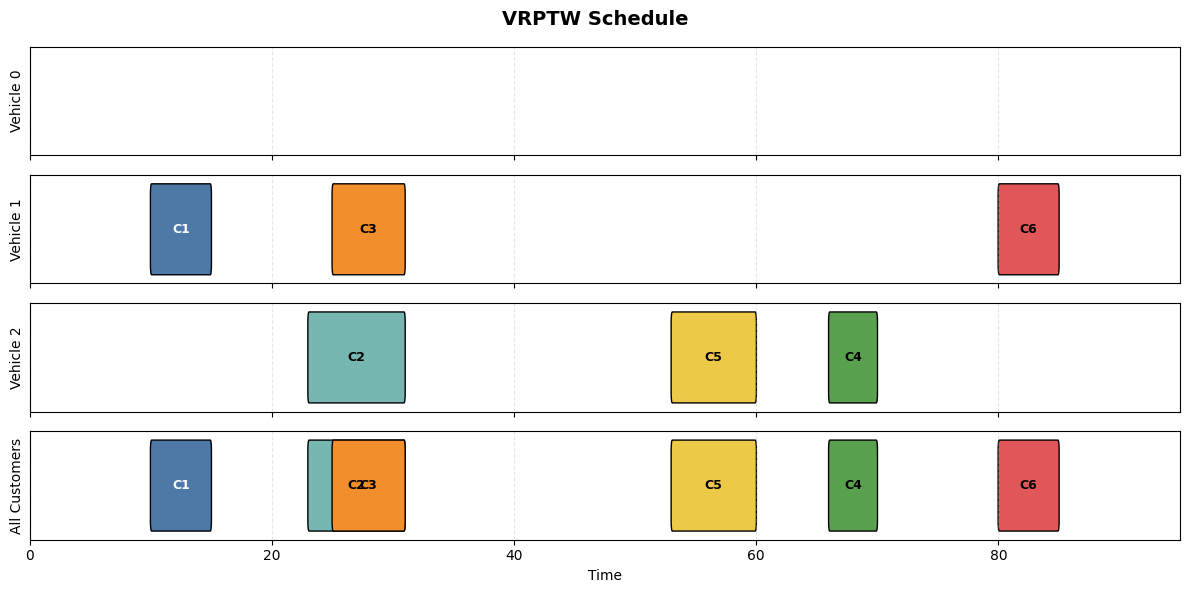

In [11]:
if result in (SAT, OPTIMUM):
    visu.reset()
    makespan = max(interval_value(main_visits[c]).end for c in range(n_customers))
    visu.timeline("VRPTW Schedule", origin=0, horizon=makespan + 10)
    
    # One panel per vehicle
    for v in range(n_vehicles):
        visu.panel(f"Vehicle {v}")
        
        # Only show customer visits, not depot
        for c in range(n_customers):
            val = interval_value(visits[v][c])
            if val is not None:
                customer_id = c + 1
                visu.interval(
                    val.start, val.end,
                    f"C{customer_id}",
                    color=customer_id
                )
    
    # Panel showing all visits (overview)
    visu.panel("All Customers")
    for c in range(n_customers):
        val = interval_value(main_visits[c])
        visu.interval(val.start, val.end, f"C{c+1}", color=c+1)
    
    if visu.is_visu_enabled():
        visu.show()
    else:
        print("Visualization disabled (matplotlib not available)")

## Extensions

### Minimize Number of Vehicles

To minimize vehicles used instead of makespan:

In [12]:
# Example: Minimize number of vehicles used
# (not applied to model above)

# Count vehicles that have at least one visit
# vehicle_used[v] = 1 if any visit on vehicle v is present
# minimize(Sum(vehicle_used))

print("To minimize vehicles:")
print("  1. Create binary variables for vehicle usage")
print("  2. Link to presence of visits: vehicle_used[v] >= presence(visits[v][c])")
print("  3. minimize(Sum(vehicle_used))")

To minimize vehicles:
  1. Create binary variables for vehicle usage
  2. Link to presence of visits: vehicle_used[v] >= presence(visits[v][c])
  3. minimize(Sum(vehicle_used))


### Exact Travel Distance (CP Optimizer Approach)

The proper formulation for minimizing total travel distance uses `type_of_next`:

```cpp
// CP Optimizer (C++) pattern:
// 1. Add depot interval to each route (size 0, fixed at time 0)
// 2. Build extended transition matrix M including depot
// 3. Use type_of_next to compute arc costs

IloNumArray2 M(env, n_customers + 2);  // Include last, absent types
// M[i][j] = travel from type i to type j
// M[i][last] = travel from i to depot (return)
// M[i][absent] = 0 (no cost for absent intervals)

// Objective: sum over all intervals
for (int k = 0; k < n_vehicles; ++k) {
    for (int i = 0; i < n_customers + 1; ++i) {
        distance += M[type_i][IloTypeOfNext(route[k], visit[k][i], last, absent)];
    }
}
model.add(IloMinimize(env, distance));
```

Key elements:
1. **Depot interval** per vehicle (size 0, fixed at time 0)
2. **Extended transition matrix** with depot-customer and customer-depot costs
3. **`type_of_next(seq, interval, last_value, absent_value)`** returns successor type
4. **Element constraint** to look up `M[current_type][next_type]`

### Heterogeneous Fleet

Different vehicles with different capacities:

In [13]:
# Example: Heterogeneous fleet
vehicle_capacities = [20, 15, 10]  # Different capacities

print("For heterogeneous fleet:")
print("  - Use vehicle-specific capacity in constraints")
print("  - Can also have vehicle-specific costs")
print(f"  - Example capacities: {vehicle_capacities}")

For heterogeneous fleet:
  - Use vehicle-specific capacity in constraints
  - Can also have vehicle-specific costs
  - Example capacities: [20, 15, 10]


### Visit Synchronization

In many routing applications, some visits must be coordinated:
- **Pickup-Delivery**: Pickup must occur before delivery
- **Synchronized Services**: Multiple visits at the same time (e.g., team service)
- **Precedence**: One customer must be visited before another

In [14]:
# Example: Visit synchronization constraints
# (not applied to model above - showing patterns)

print("=== Visit Synchronization Patterns ===")
print()

# Pattern 1: Pickup-Delivery precedence
# Customer 1 (pickup) must be visited before Customer 4 (delivery)
print("1. Pickup-Delivery (precedence):")
print("   # Pickup at C1 must finish before delivery at C4 starts")
print("   satisfy(end_before_start(main_visits[0], main_visits[3]))")
print()

# Pattern 2: Same-time visits (synchronized service)
# Customer 2 and Customer 3 must be served at the same time (team service)
print("2. Synchronized visits (same start time):")
print("   # C2 and C3 must start at the same time")
print("   from pycsp3_scheduling import start_at_start")
print("   satisfy(start_at_start(main_visits[1], main_visits[2]))")
print()

# Pattern 3: Time-lagged visits
# Customer 5 must start exactly 10 time units after Customer 2 ends
print("3. Time-lagged visits:")
print("   # C5 starts 10 time units after C2 ends")
print("   from pycsp3_scheduling import end_before_start")
print("   satisfy(end_before_start(main_visits[1], main_visits[4], delay=10))")
print()

# Pattern 4: Same vehicle constraint
# Customer 1 and Customer 4 must be on the same vehicle (pickup-delivery pair)
print("4. Same vehicle (pickup-delivery on same route):")
print("   # C1 and C4 must be on the same vehicle")
print("   for v in range(n_vehicles):")
print("       # If C1 is on vehicle v, then C4 must also be on vehicle v")
print("       satisfy(presence_of(visits[v][0]) == presence_of(visits[v][3]))")
print()

# Pattern 5: Synchronize constraint (same time and same vehicle)
print("5. Synchronize (intervals share same start time):")
print("   # All visits in a group start at the same time as a reference interval")
print("   satisfy(synchronize(reference_interval, [sync_visit1, sync_visit2]))")

=== Visit Synchronization Patterns ===

1. Pickup-Delivery (precedence):
   # Pickup at C1 must finish before delivery at C4 starts
   satisfy(end_before_start(main_visits[0], main_visits[3]))

2. Synchronized visits (same start time):
   # C2 and C3 must start at the same time
   from pycsp3_scheduling import start_at_start
   satisfy(start_at_start(main_visits[1], main_visits[2]))

3. Time-lagged visits:
   # C5 starts 10 time units after C2 ends
   from pycsp3_scheduling import end_before_start
   satisfy(end_before_start(main_visits[1], main_visits[4], delay=10))

4. Same vehicle (pickup-delivery on same route):
   # C1 and C4 must be on the same vehicle
   for v in range(n_vehicles):
       # If C1 is on vehicle v, then C4 must also be on vehicle v
       satisfy(presence_of(visits[v][0]) == presence_of(visits[v][3]))

5. Synchronize (intervals share same start time):
   # All visits in a group start at the same time as a reference interval
   satisfy(synchronize(reference_interva

## Summary

This notebook demonstrated VRPTW modeling with:

1. **Optional intervals** for vehicle-customer assignments
2. **Alternative constraints** for customer coverage  
3. **Sequence variables** with transition matrices for travel times
4. **Capacity constraints** using `presence_time()`
5. **Visit synchronization** patterns (precedence, same-time, time-lagged)

### Key Modeling Pattern

```python
# For each customer, one visit per vehicle (optional)
visits[v][c] = IntervalVar(start=(earliest, latest), size=service, optional=True)

# Main visit (abstract) for the customer
main_visit[c] = IntervalVar(start=(earliest, latest), size=service)

# Exactly one vehicle visits each customer
satisfy(alternative(main_visit[c], [visits[v][c] for v in vehicles]))

# Travel times between customers on each route
satisfy(SeqNoOverlap(route[v], transition_matrix=travel_times))
```

### Objective Options

| Objective | Approach | Notes |
|-----------|----------|-------|
| Min makespan | `minimize(Maximum(end_time(...)))` | Latest completion |
| Min total time | `minimize(Sum(end_time(...)))` | Proxy for travel |
| Min vehicles | `minimize(Sum(vehicle_used[v]))` | Count active routes |
| **Min travel** | **type_of_next + Element** | **See CP Optimizer approach** |

### Synchronization Patterns

| Pattern | Constraint | Use Case |
|---------|------------|----------|
| Precedence | `end_before_start(a, b)` | Pickup before delivery |
| Same time | `start_at_start(a, b)` | Team service |
| Time lag | `end_before_start(a, b, delay=k)` | Minimum separation |
| Same vehicle | `presence_of(v_a) == presence_of(v_b)` | Pickup-delivery pairs |
| Synchronize | `synchronize(ref, [a, b])` | Coordinated visits |